# Implementing Ridge Regression
In this notebook we analyze data using regularized linear regression. The goal is to predict the miles per gallon a car will get using six features about that car.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

% matplotlib inline

sns.set_style('whitegrid')
sns.set_context('poster')

data_path = os.path.join('data', 'cars')

The data is broken into training and testing sets. Each row in both $X$ objects contain six features for a single car and an additional $1$ in the $7^{th}$ dimension. The same row in the corresponding $y$ object contains the MPG for that car.

In [2]:
# load data

X_train = np.genfromtxt(os.path.join(data_path, 'X_train.csv'), delimiter = ',')
y_train = np.genfromtxt(os.path.join(data_path, 'y_train.csv'))

X_test = np.genfromtxt(os.path.join(data_path, 'X_test.csv'), delimiter = ',')
y_test = np.genfromtxt(os.path.join(data_path, 'y_test.csv'))

print('X_train has {} observations and {} features'.format(X_train.shape[0], X_train.shape[1]))
print('y_train has {} labels'.format(len(y_train)))
print('X_test has {} observations and {} features'.format(X_test.shape[0], X_test.shape[1]))
print('y_test has {} labels'.format(len(y_test)))

X_train has 350 observations and 7 features
y_train has 350 labels
X_test has 42 observations and 7 features
y_test has 42 labels


Below, we define the estimator **RidgeRegression** that solves the following minimization problem:

$$\mathcal{L} = \lambda \left\|w\right\|^2_2 + \sum_{i=1}^{350}\left\|y_i-x_i^Tw\right\|^2_2$$

Two analytical methods for minimizing the loss are implemented:
- **normal**: The weights $w_{RR}$ that minimize $\mathcal{L}$ are solved using the modified normal equation $w_{RR} = (\lambda I + X^TX)^{−1}X^Ty$
- **svd**: The weights $w_{RR}$ that minimize $\mathcal{L}$ are solved by taking the singular value decomposition of $X = USV^T$, so that $w_{RR} = VS^{-1}_{\lambda}U^Ty$, where $S^{-1}_{\lambda}$ is a diagonal matrix whose $i^{th}$ diagonal component is equal to $\frac{S_{ii}}{\lambda + S^2_{ii}}$.

In [3]:
# %%writefile modules/ridge.py
# define Ridge Regression class

class RidgeRegression:
    
    def __init__(self, lambd = 3, method = 'svd'):
        self.lambd = lambd
        self.method = method
    
    def fit(self, X, y):
        self.n_features = X.shape[1]
        if self.method == 'normal':
            # solve for weights w
            first = np.linalg.inv(self.lambd * np.eye(self.n_features) + np.dot(X.T,X))
            second = np.dot(X.T, y)
            self.weights = np.dot(first, second)
            
            # calculate degrees of freedom using previously computed 'first' variable
            df_matrix = X.dot(first).dot(X.T)
            self.df = np.trace(df_matrix)
        elif self.method == 'svd':
            # the svd function returns V^T as V, which should be corrected for clarity
            # S is a vector of singular values rather than a diagonal matrix
            U, S, V = np.linalg.svd(X, full_matrices=False)
            V = V.T 
            S_lambda_inv = S / (self.lambd + S**2) # also a vector of values
            S_lambda_inv_diag = np.diag(S_lambda_inv) # convert vector to diagonal matrix
            self.weights = V.dot(S_lambda_inv_diag).dot(U.T).dot(y)
            self.df = np.sum(S**2 / (self.lambd + S**2))
        return self      
        
    def predict(self, X):
        return np.dot(X, self.weights)

def rmse(y, y_pred):
    mse = np.mean((y - y_pred)**2)
    rmse = np.sqrt(mse)
    return rmse

Below we solve for $w_{RR}$ for all values of $\lambda \in \{0, 1, 2, ..., 5000\}$, and then plot all $7$ weights as a function of $df(\lambda)$, the degrees of freedom. Because the **weight** dimension and **year** dimension take on significantly more extreme values than the other features as more degrees of freedom are afforded to the model, we can infer that perturbations in **weight** or **year** most directly affect the prediction for $y_i$. That is to say, **weight** and **year** are the most important predictors of **mileage**.

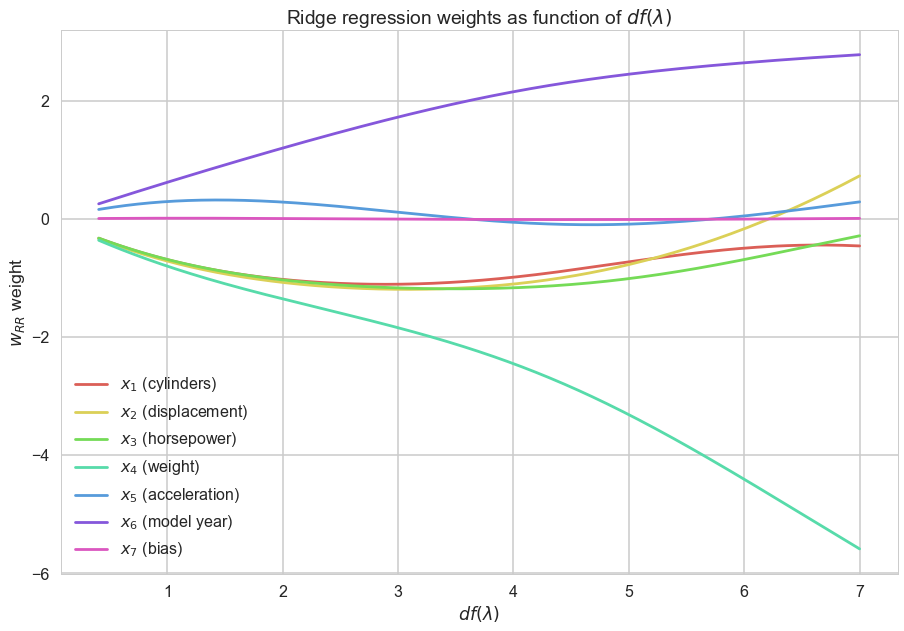

In [4]:
# solve for w_RR

lambdas = np.arange(0, 5001)

models = [RidgeRegression(l, method = 'svd').fit(X_train, y_train) for l in lambdas]
weights = [model.weights for model in models]
dfs = [model.df for model in models]

features = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'bias']
colors = sns.set_palette('hls', 7)

plt.figure(figsize = (15,10))
ax = plt.gca()
ax.plot(dfs, weights)
ax.set(xlabel = '$df(\lambda)$', ylabel = '$w_{RR}$ weight',
       title = 'Ridge regression weights as function of $df(\lambda)$')
ax.legend(['$x_{}$ ({})'.format(i, feature) for i, feature in zip(range(1,8), features)])

Below, we solve $w_{RR}$ and predict all $42$ test cases for all values of $\lambda \in \{0, 1, 2, ..., 50\}$. Plotting the RMSE on the test set as a function of $\lambda$ suggests that increasing regularization does not improve the performance of the model. Thus, the model performs best on test data without regularization, effectively meaning that we should choose ordinary least squares regression.

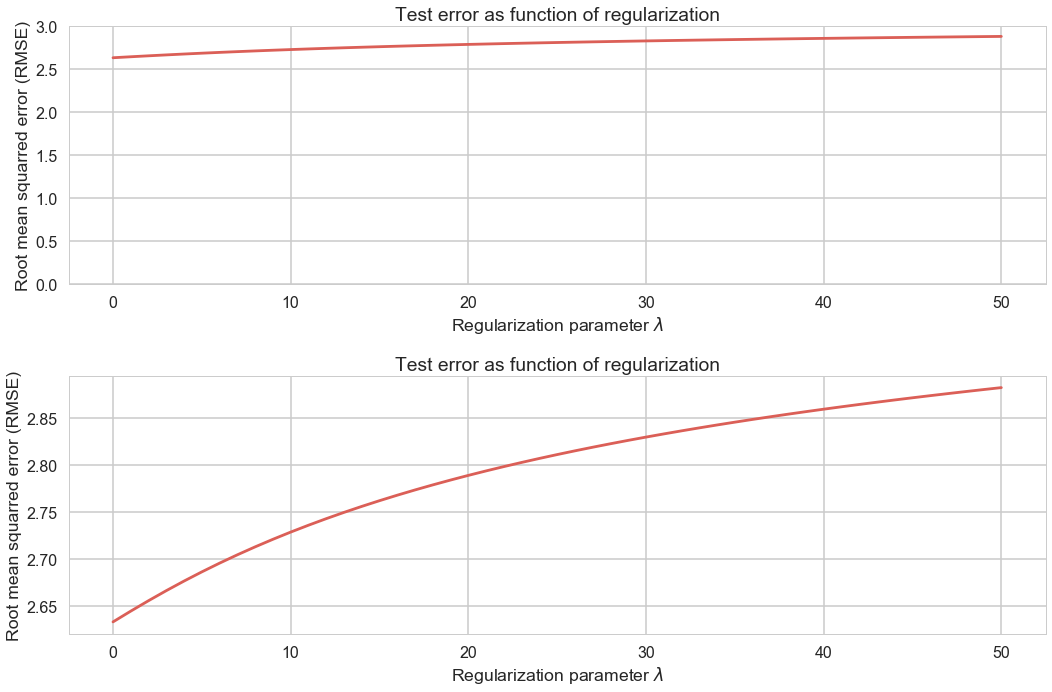

In [5]:
lambdas = range(0, 51)
rmses = [rmse(y_test, RidgeRegression(lambd, method='normal').fit(X_train, y_train).predict(X_test)) \
         for lambd in lambdas]

fig, axes = plt.subplots(2, 1, figsize = (15,10))
axes[0].plot(lambdas, rmses)
axes[0].set(title = 'Test error as function of regularization',
       xlabel = 'Regularization parameter $\lambda$',
       ylabel = 'Root mean squarred error (RMSE)',
       ylim = (0, 3))
axes[1].plot(lambdas, rmses)
axes[1].set(title = 'Test error as function of regularization',
       xlabel = 'Regularization parameter $\lambda$',
       ylabel = 'Root mean squarred error (RMSE)')

plt.tight_layout()

The cell below performs the same calculations as the one above, but does so for all $p \in \{1, 2, 3\}$, where $p$ denotes the order of polynomial features derived from then appended to the training data. Based on the  plots below, we see that with proper regularization, a value of $p = 2$ yields the lowest test RMSE.

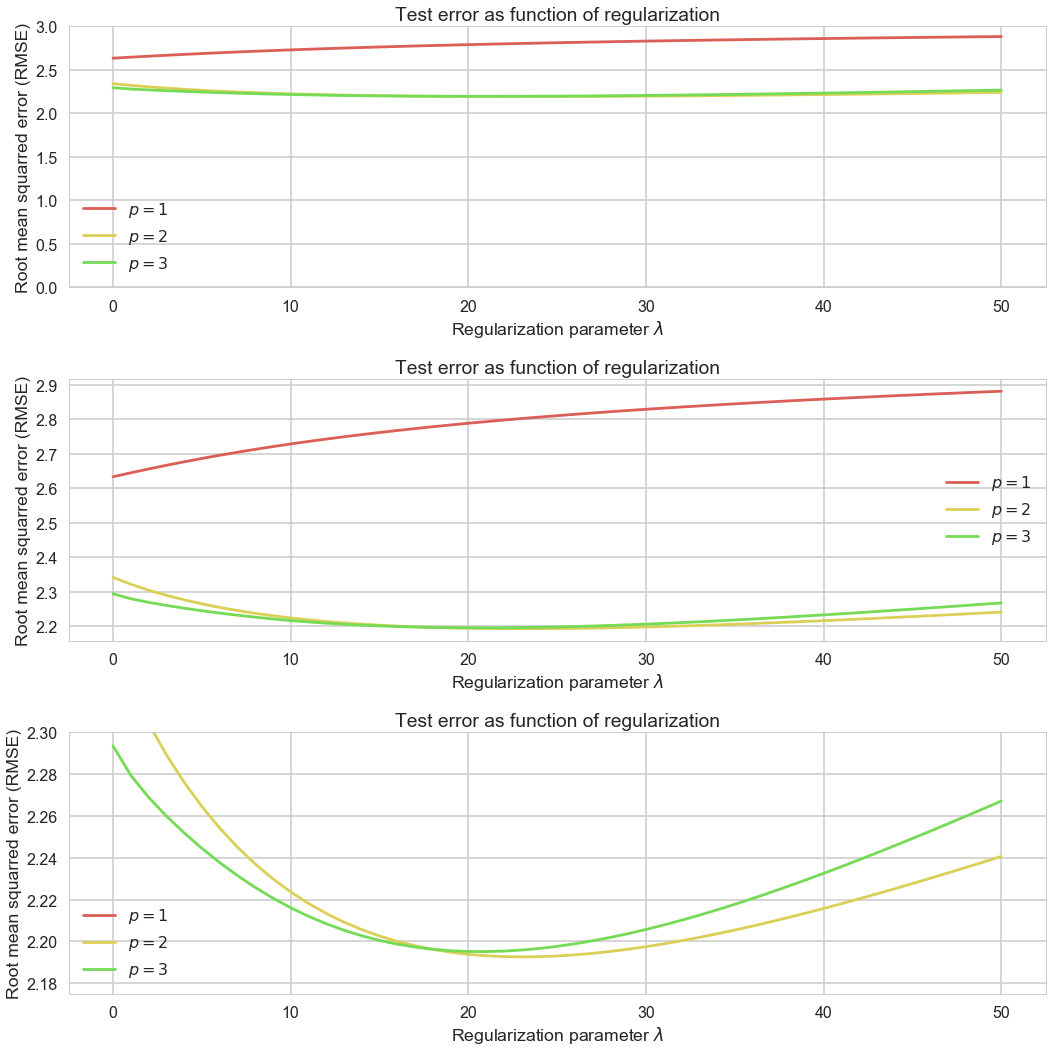

In [6]:
lambdas = range(0, 51)
fig, axes = plt.subplots(3, 1, figsize = (15,15))

for p in range(1, 4):
    if p == 1:
        X_train_poly = X_train[:]
        X_test_poly = X_test[:]
    elif p > 1:
        X_train_poly = np.hstack([X_train_poly, X_train[:,:-1] ** p])
        X_test_poly = np.hstack([X_test_poly, X_test[:,:-1] ** p])
        
    rmses = [rmse(y_test, RidgeRegression(lambd, method='normal').fit(X_train_poly, y_train).predict(X_test_poly)) \
             for lambd in lambdas]

    axes[0].plot(lambdas, rmses, label = '$p = {}$'.format(p))
    axes[1].plot(lambdas, rmses, label = '$p = {}$'.format(p))
    axes[2].plot(lambdas, rmses, label = '$p = {}$'.format(p))
    
axes[0].set(title = 'Test error as function of regularization',
           xlabel = 'Regularization parameter $\lambda$',
           ylabel = 'Root mean squarred error (RMSE)',
           ylim = (0, 3))
axes[1].set(title = 'Test error as function of regularization',
           xlabel = 'Regularization parameter $\lambda$',
           ylabel = 'Root mean squarred error (RMSE)')
axes[2].set(title = 'Test error as function of regularization',
           xlabel = 'Regularization parameter $\lambda$',
           ylabel = 'Root mean squarred error (RMSE)',
           ylim = (2.175, 2.3))
axes[0].legend()
axes[1].legend()
axes[2].legend()


plt.tight_layout()

When second order terms are introduced, least squares regression will overfit the data (since the number of training examples are limited). Thus, under these conditions, the use of regularization, particularly with $\lambda \approx 22.5$ yields the best performance out of all possible combinations of $\lambda$ and $p$.